## File with dataset used for paper figures (after different formatation)

### Warning: Due to a misstep, the original figures will have to be changed with a new analysis

### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis without CHT, CFN and SB samples.

### Peak alignments analysed: 
#### 1 - 1st alignment: min_sample = 2, 2nd alignment: min_sample = 1 - NAME: 2-1 / Original
#### 2 - 1st alignment: min_sample = 1, 2nd alignment: min_sample = 2 - NAME: 1-2

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

In [3]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
    final_file.columns = mi
    return final_file

## Similarity analysis

aligned_all_neg = negative dataset alignment 2-1 (Original) / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 2-1 (Original) / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 1-6 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 1-6 / aligned_pos2 - binary matrix equivalent

### Read aligned data of the 1st alignment 2-1 - Analysis of this one first

In [4]:
aligned_all_pos_f = pd.HDFStore('alignments.h5').get('groups_1ppm_min2_all_1ppm_pos')
aligned_all_neg_f = pd.HDFStore('alignments.h5').get('groups_1ppm_min2_all_1ppm_neg')

aligned_all_neg = aligned_all_neg_f.iloc[:,:33]
aligned_all_pos = aligned_all_pos_f.iloc[:,:33]

### Removing features that only appeared in CHT, CFN and SB samples

In [5]:
# Function keep_atleast accepts argument min_samples
# (integer: number of samples, [0,1[: fraction to keep)

aligned_all_neg = transf.keep_atleast(aligned_all_neg, min_samples=2)
aligned_all_pos = transf.keep_atleast(aligned_all_pos, min_samples=2)

### Compute m/z similarities - Not present in yeast_new (maybe take out in future versions except first cell)

In [6]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [7]:
print(sim_pos)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10    23  ...   22    35    36  \
14  330  277  253  197  195  189  204  210  203   147  ...  124   173   179   
15  277  379  302  229  228  219  220  225  215   175  ...  138   192   195   
16  253  302  355  217  215  211  206  207  201   159  ...  142   180   182   
29  197  229  217  667  514  526  227  229  232   304  ...  149   357   354   
30  195  228  215  514  612  471  232  232  231   280  ...  150   329   328   
31  189  219  211  526  471  624  228  233  235   290  ...  148   351   346   
8   204  220  206  227  232  228  489  399  369   178  ...  135   190   194   
9   210  225  207  229  232  233  399  501  381   180  ...  138   203   204   
10  203  215  201  232  231  235  369  381  471   177  ...  138   211   212   
23  147  175  159  304  280  290  178  180  177  1487  ...  119   480   486   
24  147  172  158  304  282  293  183  186  184  1246  ...  117   498   505   
25  142  

In [8]:
print(sim_neg)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10   23  ...   22   35   36   37  \
14  442  286  345  185  182  169  168  180  180   34  ...  144  135  134  147   
15  286  319  222  120  117  107  144  158  156   25  ...  123  128  123  136   
16  345  222  378  173  170  158  168  182  178   34  ...  108  130  128  141   
29  185  120  173  674  637  588  143  151  150   87  ...  108  153  178  175   
30  182  117  170  637  677  591  142  150  149   87  ...  110  155  182  179   
31  169  107  158  588  591  628  128  135  135   86  ...  105  139  161  155   
8   168  144  168  143  142  128  370  331  339  118  ...  114  141  113  148   
9   180  158  182  151  150  135  331  402  371  110  ...  122  147  118  155   
10  180  156  178  150  149  135  339  371  410  119  ...  118  144  115  153   
23   34   25   34   87   87   86  118  110  119  350  ...   39   25   21   25   
24   45   32   44   96   96   95  126  119  128  314  ...   50   3

### Clustermap peak list function

In [9]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


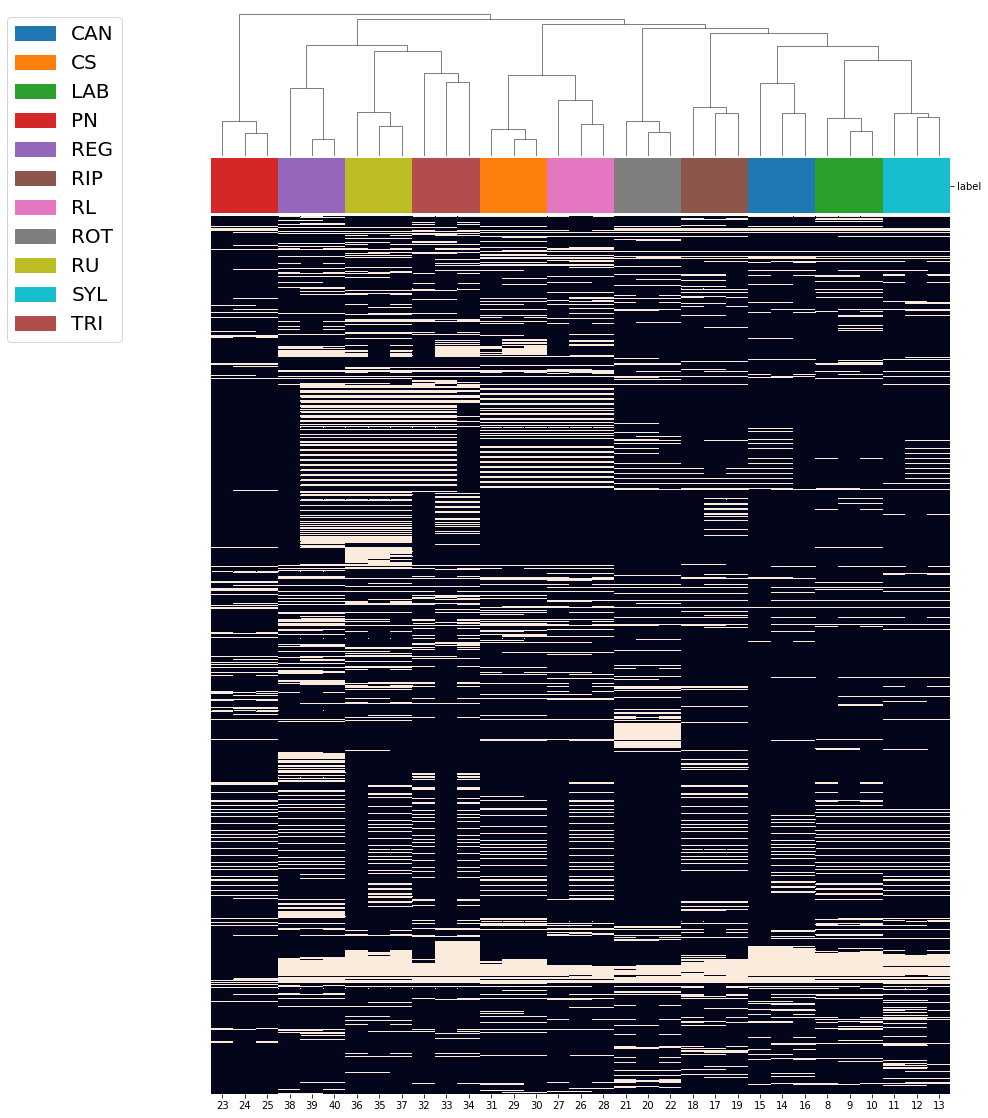

In [10]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


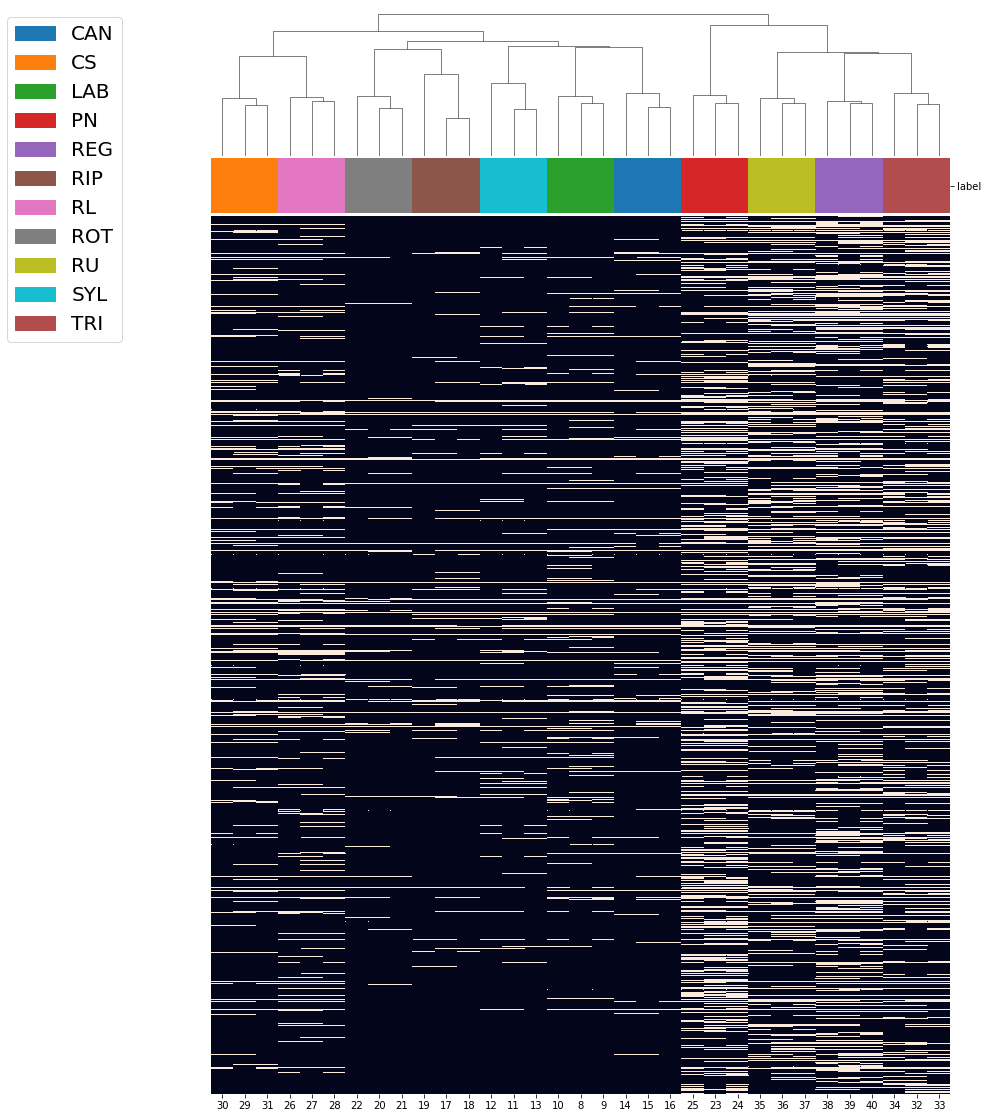

In [11]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Global metadata for consistency between tables and plots

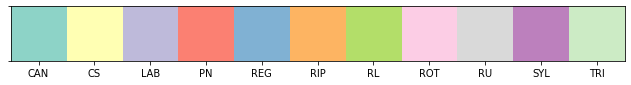

In [12]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('Set3', 11)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

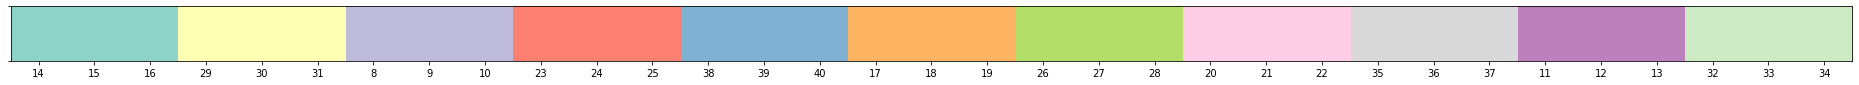

In [13]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3/4 types of processing are made:

(Imp (Ionly) - Only Missing Value Imputation).

P - Missing Value Imputation and Pareto Scaling.

NP - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

NGP - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [14]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [15]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.2765711904763, 0.0005288095237574453)


In [16]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.26202)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765711904763)

## Similarity analysis (Jaccard)

In [17]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

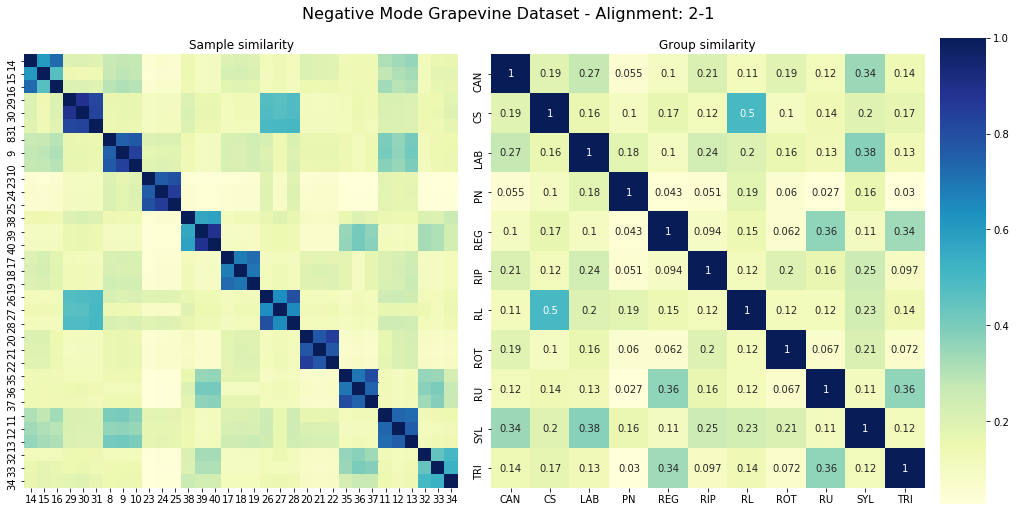

In [18]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 2-1')

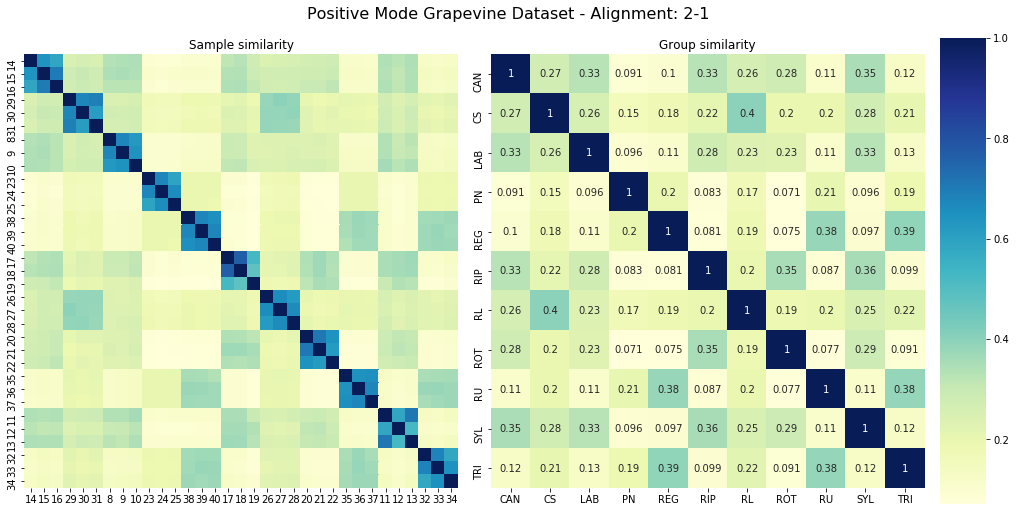

In [19]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 2-1')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [20]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = 0.91568)


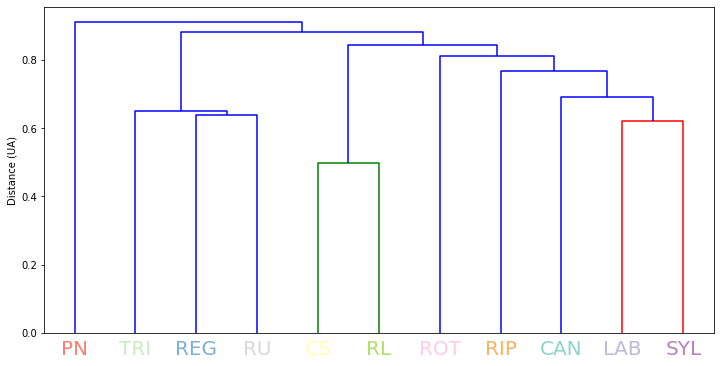

In [21]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 2-1 (cophenetic = 0.92732)


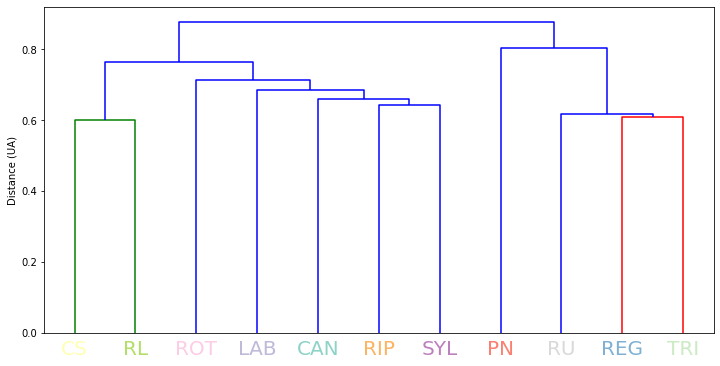

In [22]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 2-1 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.

In [23]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - 2-1 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

Each feature appears at least in 2 samples of the 3 replicates in any of the grapevine varieties. 2_1 in figures.

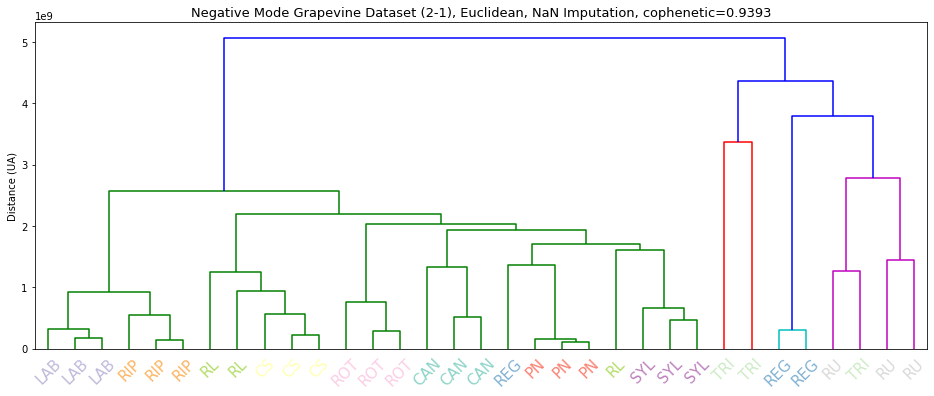

In [24]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

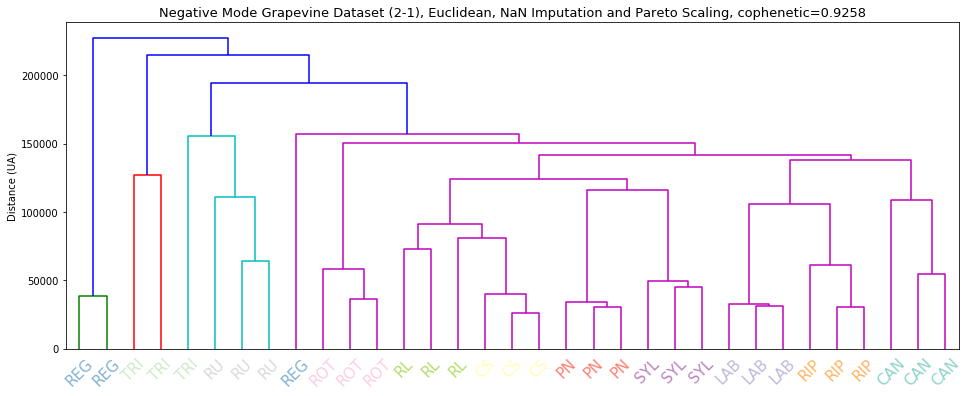

In [25]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

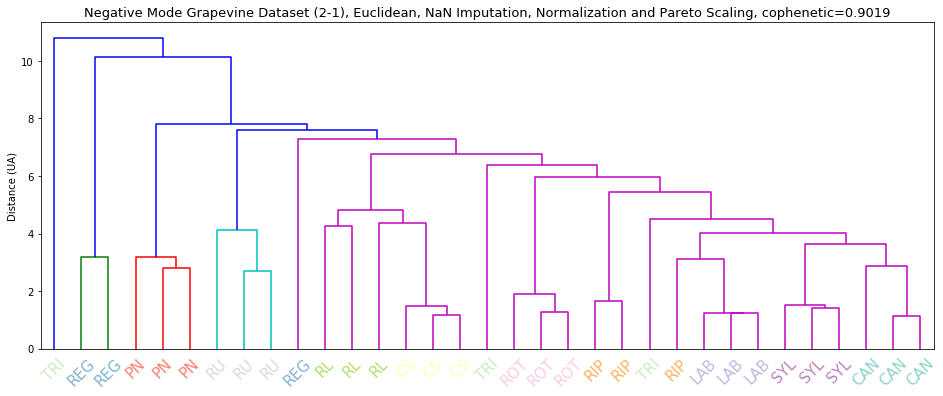

In [26]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

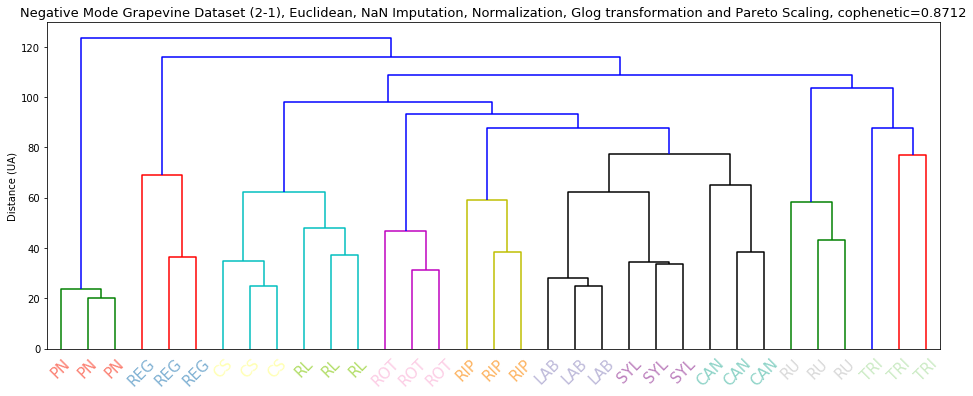

In [27]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

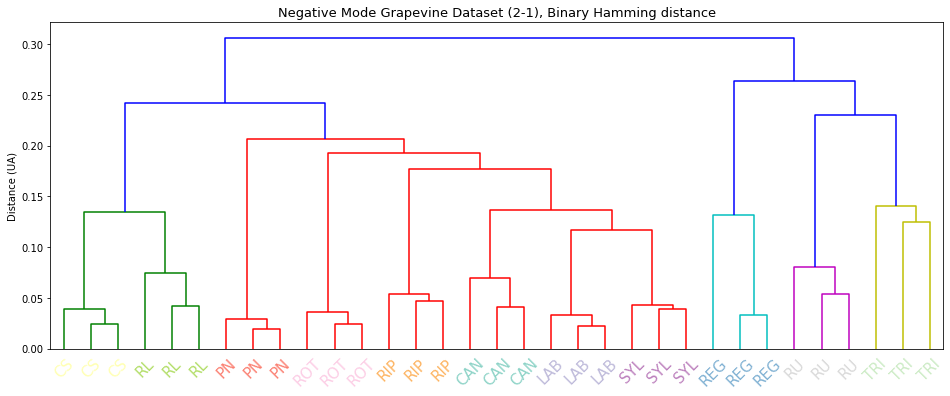

In [28]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 2-1 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

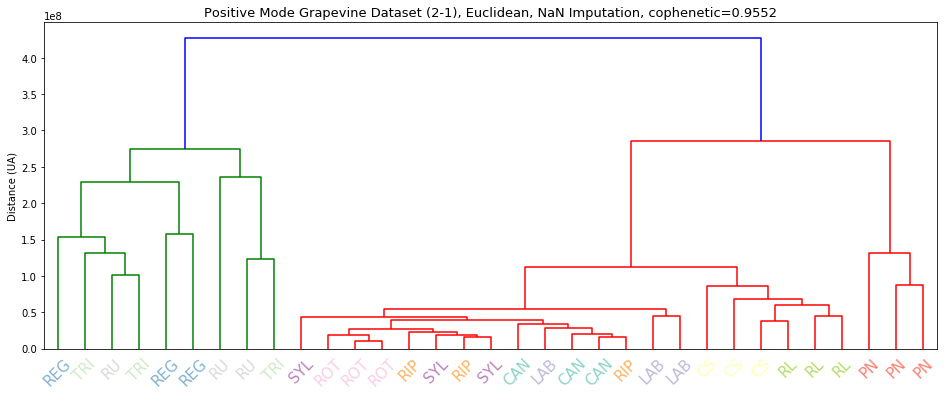

In [29]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

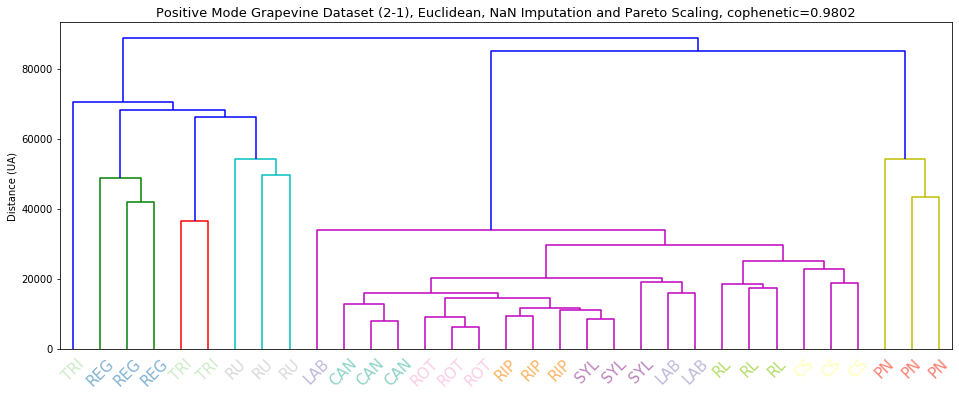

In [30]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

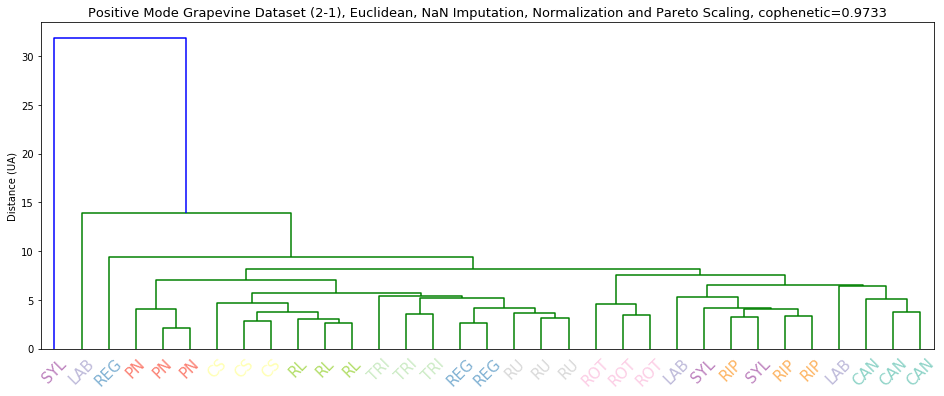

In [31]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

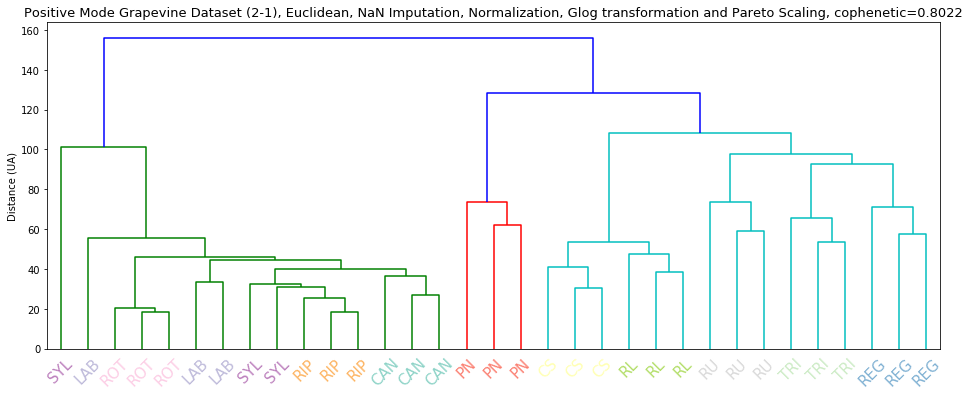

In [32]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

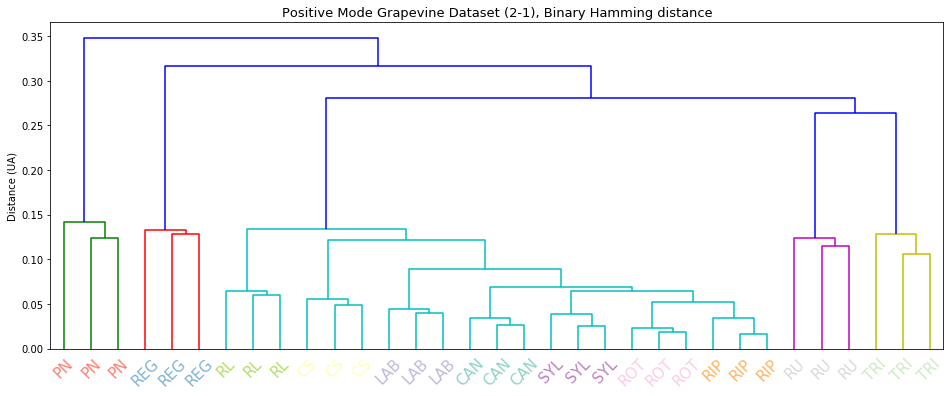

In [33]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

## 2nd Peak Alignment - 1-2 - "True" Non-Bias

Presented with 2 following the names. Example: treat_neg2.

Same types of processing as before.

### 1-2 alignment 

Each feature appears in at least 2 of the total 39 samples (before the trim down to 30 samples. Appears as 1_2 in figures.

In [34]:
aligned_all_pos2_f = pd.HDFStore('alignments.h5').get('all_1ppm_min2_pos')
aligned_all_neg2_f = pd.HDFStore('alignments.h5').get('all_1ppm_min2_neg')

aligned_all_neg2 = aligned_all_neg2_f.iloc[:,:33]
aligned_all_pos2 = aligned_all_pos2_f.iloc[:,:33]

In [35]:
aligned_all_neg2 = transf.keep_atleast(aligned_all_neg2, min_samples=2)
aligned_all_pos2 = transf.keep_atleast(aligned_all_pos2, min_samples=2) 

#### Performing treatments

In [36]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.2771)
print(RefEst_Pos)

(554.2620199999996, 0.0005199999995966209)
(556.2765711904766, 0.0005288095234163848)


In [37]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.2620199999996)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.2765711904766)

### Negative Mode - 1-2 Non-Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

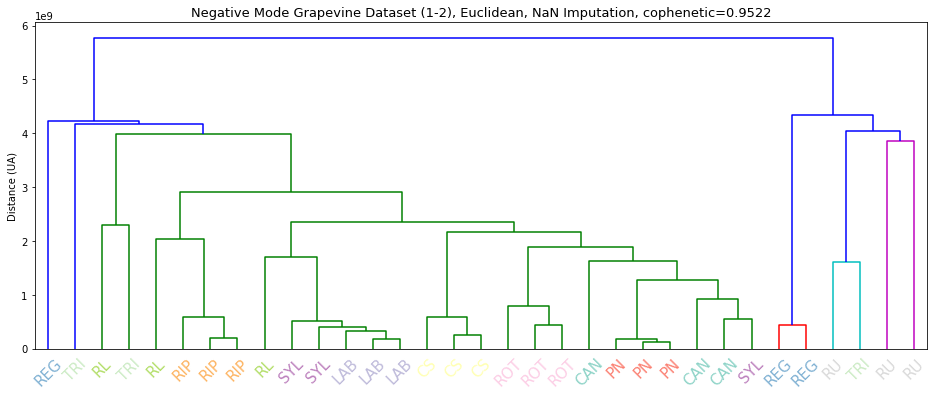

In [38]:
# Missing Value Imputation only
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg2, title)

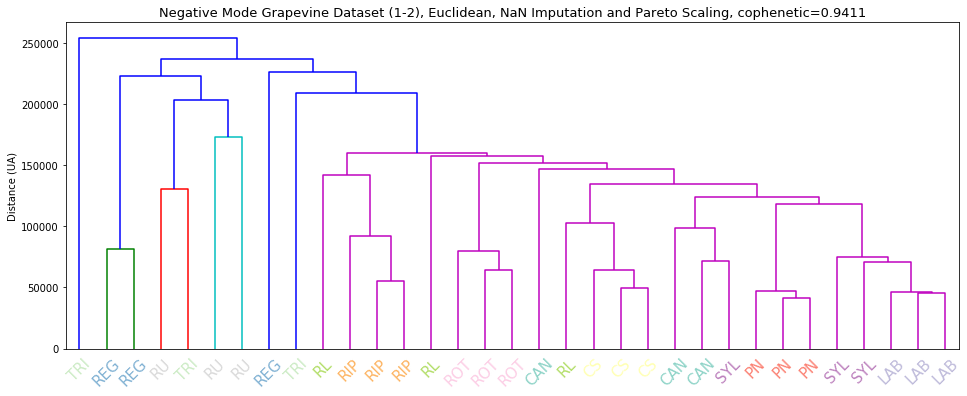

In [39]:
# Imputed and Pareto scaled
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

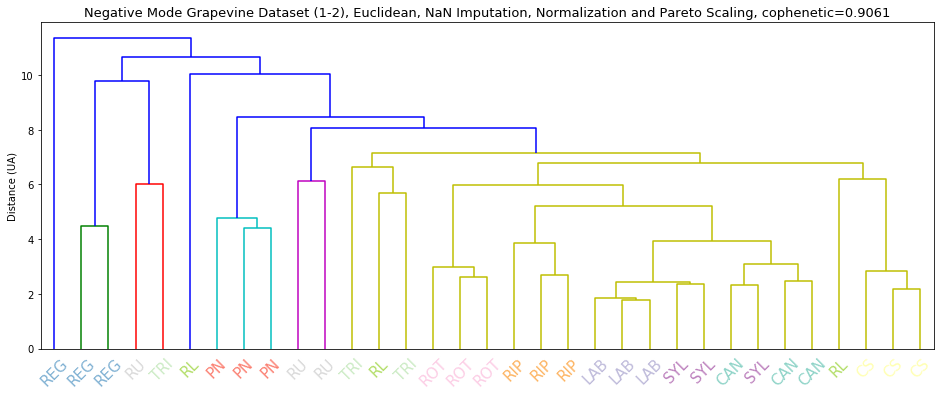

In [40]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

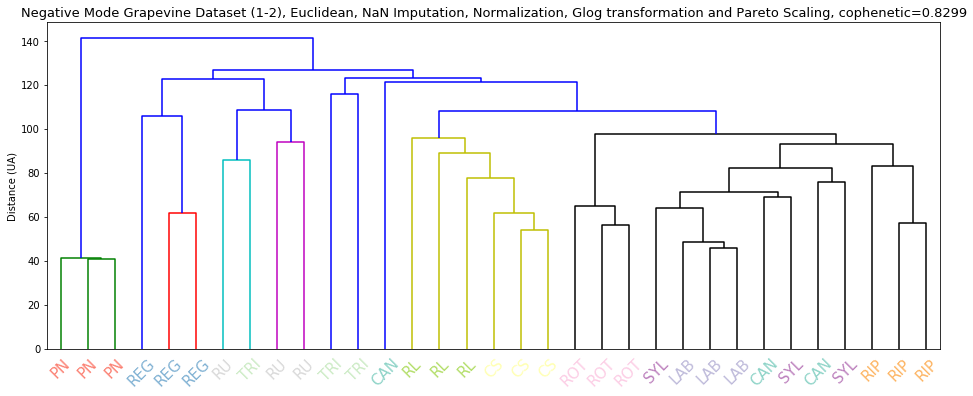

In [41]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

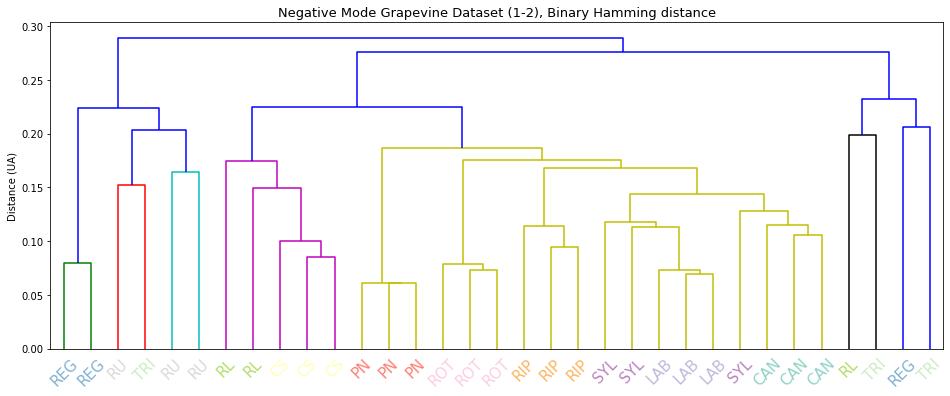

In [42]:
binary = treat_neg2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 1-6 Non-Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

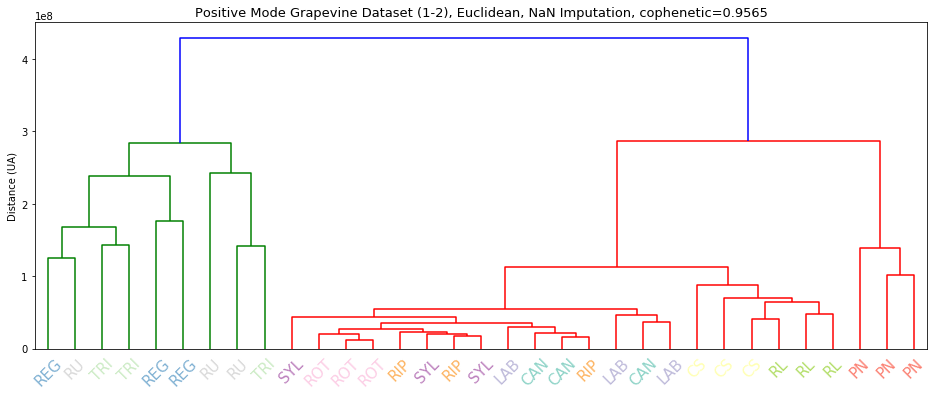

In [43]:
# Missing Value Imputation only
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos2, title)

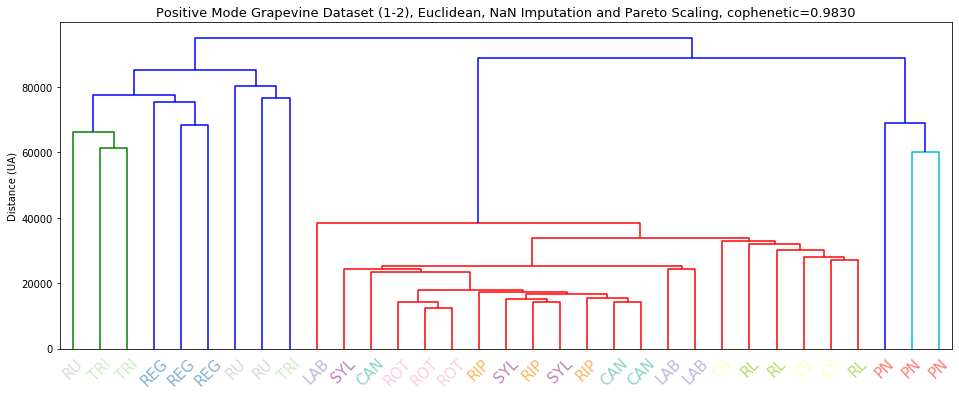

In [44]:
# Imputed and Pareto scaled
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

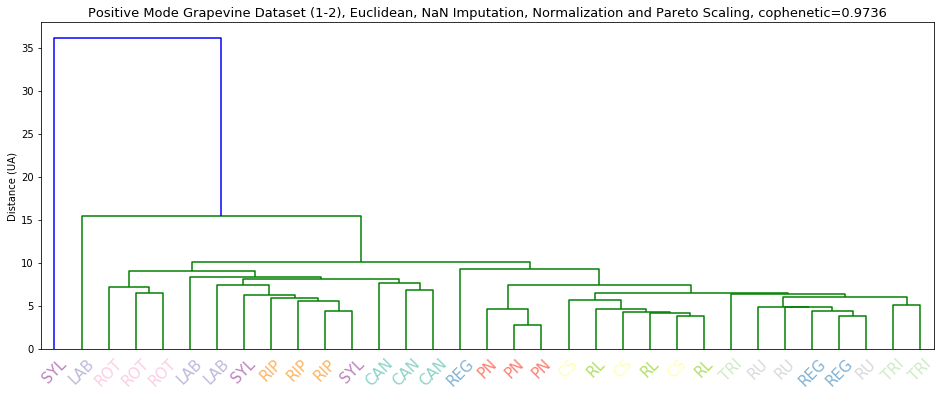

In [45]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

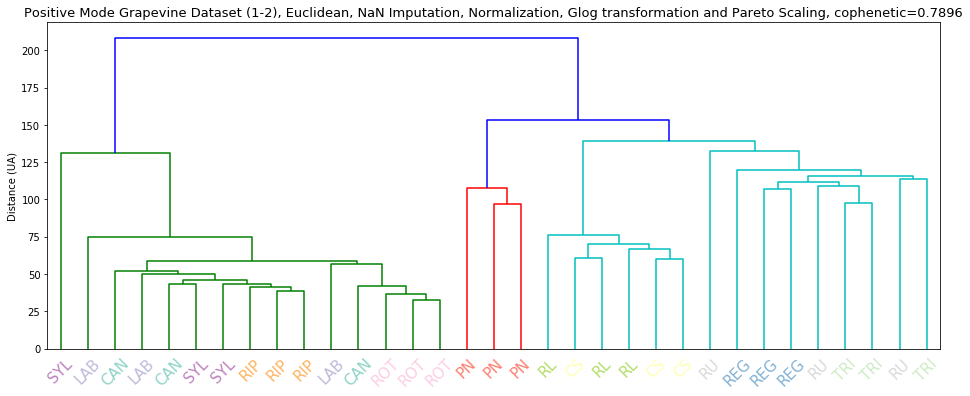

In [46]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

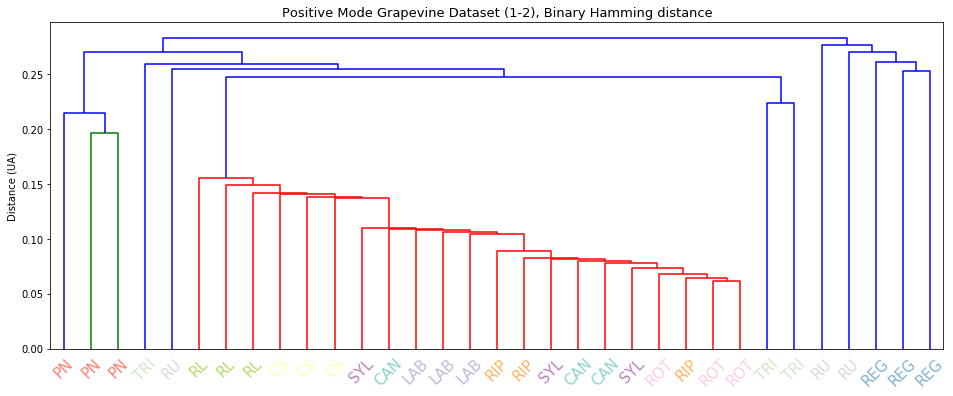

In [47]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

#### Imp/Ionly not used in this comparison

In [48]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [49]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.4767988123777397 	 1.1234404025253043e-96
Euc_P_neg-Euc_NGP_neg	 0.4114670558072352 	 3.1791377267761515e-70


According to the explanation given in the R package dendextend

In [50]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.599360472899544 	 5.53323120151996e-104
Euc_P_neg-Euc_NGP_neg	 0.4791483515981057 	 1.0305328090720132e-61


#### Cophenetic Correlation Coefficient

In [51]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [52]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.742410217928583 	 1.4679705772891247e-93
Euc_P_neg-Euc_NGP_neg	 0.6564615523552411 	 2.133862630273065e-66


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

Change between number of binary metrics to use

In [53]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [54]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']
aligned_neg2 = treat_neg2['binary']
aligned_pos2 = treat_pos2['binary']

In [55]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [56]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [57]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [58]:
#Column names and row names for the dataframes
#3 binary metrics
#colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
            #'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
#            'hamming_neg2_1', 'jaccard_neg2_1', 'yule_neg2_1',  'hamming_pos2_1', 'jaccard_pos2_1', 'yule_pos2_1']

#9 binary metrics
colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1','P_neg1_2',
            'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2','dice_neg2_1', 'hamming_neg2_1',
            'jaccard_neg2_1', 'rogerstanimoto_neg2_1', 'sokalmichener_neg2_1', 'sokalsneath_neg2_1','yule_neg2_1', 
            'kulsinski_neg2_1', 'russellrao_neg2_1','dice_pos2_1', 'hamming_pos2_1', 'jaccard_pos2_1', 'rogerstanimoto_pos2_1', 
            'sokalmichener_pos2_1', 'sokalsneath_pos2_1', 'yule_pos2_1', 'kulsinski_pos2_1', 'russellrao_pos2_1']

In [59]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [60]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


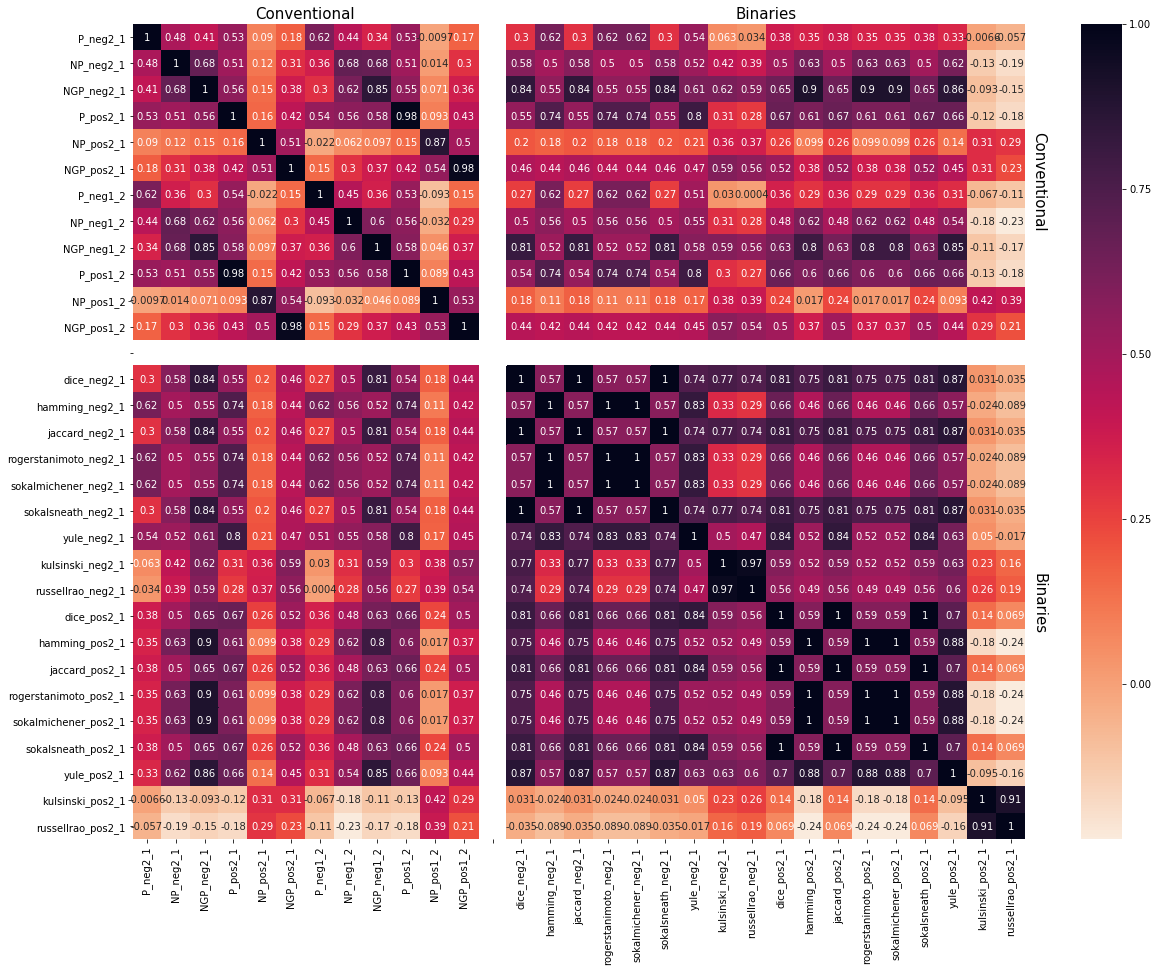

In [61]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [62]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2-1', 'pos2-1', 'neg1-2', 
                                                                                                'pos1-2', 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_KI.iloc[13+r,j*3+2]#sum(df_KI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_KI.iloc[22+r,j*3+2]#sum(df_KI.iloc[22+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
Kendall

,neg2-1,pos2-1,neg1-2,pos1-2,neg+pos
dice,0.843147,0.519055,0.813904,0.503223,2.679328
hamming,0.552074,0.375436,0.519605,0.369818,1.816933
jaccard,0.843147,0.518975,0.813904,0.503143,2.679169
rogerstanimoto,0.552074,0.375472,0.519605,0.369854,1.817006
sokalmichener,0.552074,0.375472,0.519605,0.369854,1.817006
sokalsneath,0.843147,0.518975,0.813904,0.503143,2.679169
yule,0.613288,0.451054,0.581011,0.442866,2.088219
kulsinski,0.616172,0.310729,0.587619,0.292649,1.807168
russellrao,0.586216,0.232547,0.557725,0.214981,1.591469


Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


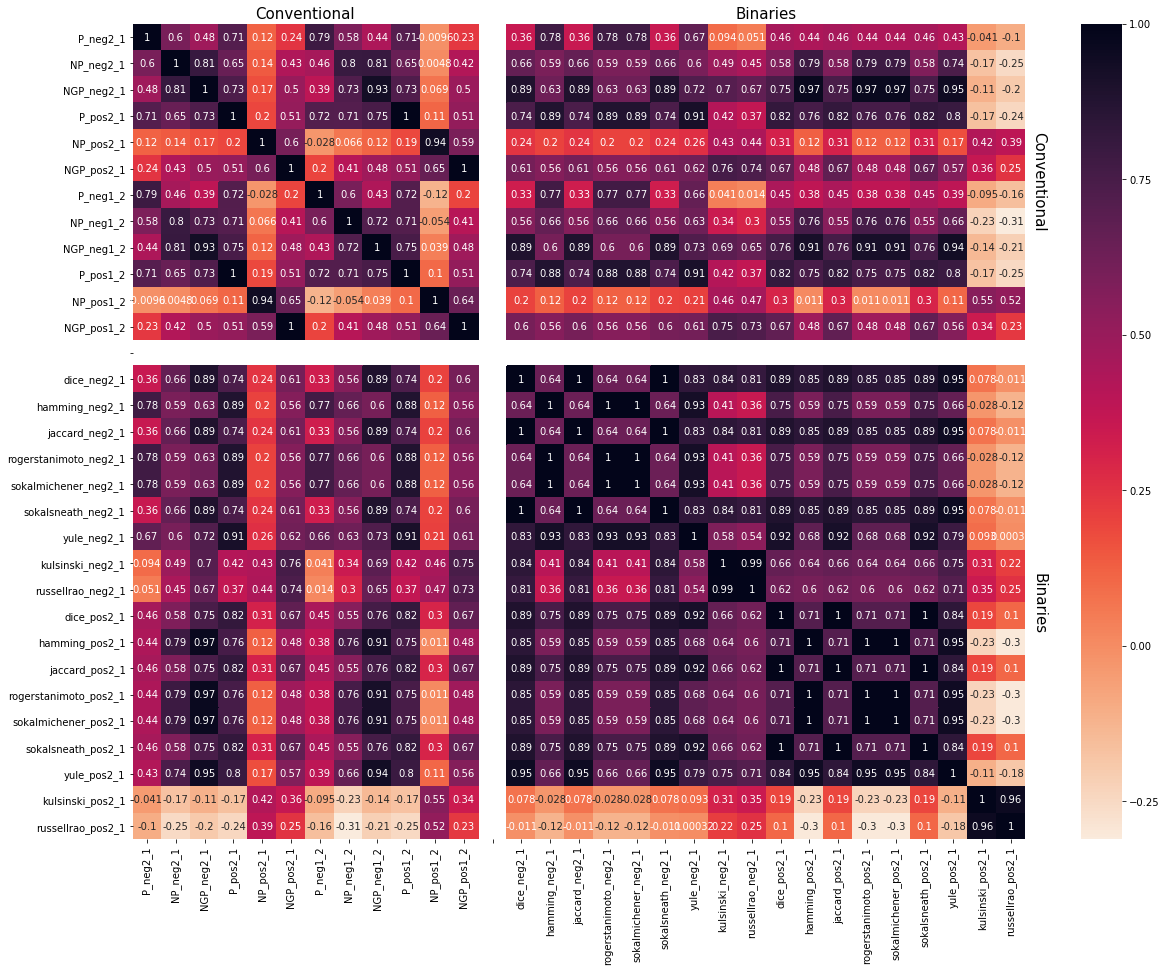

In [63]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


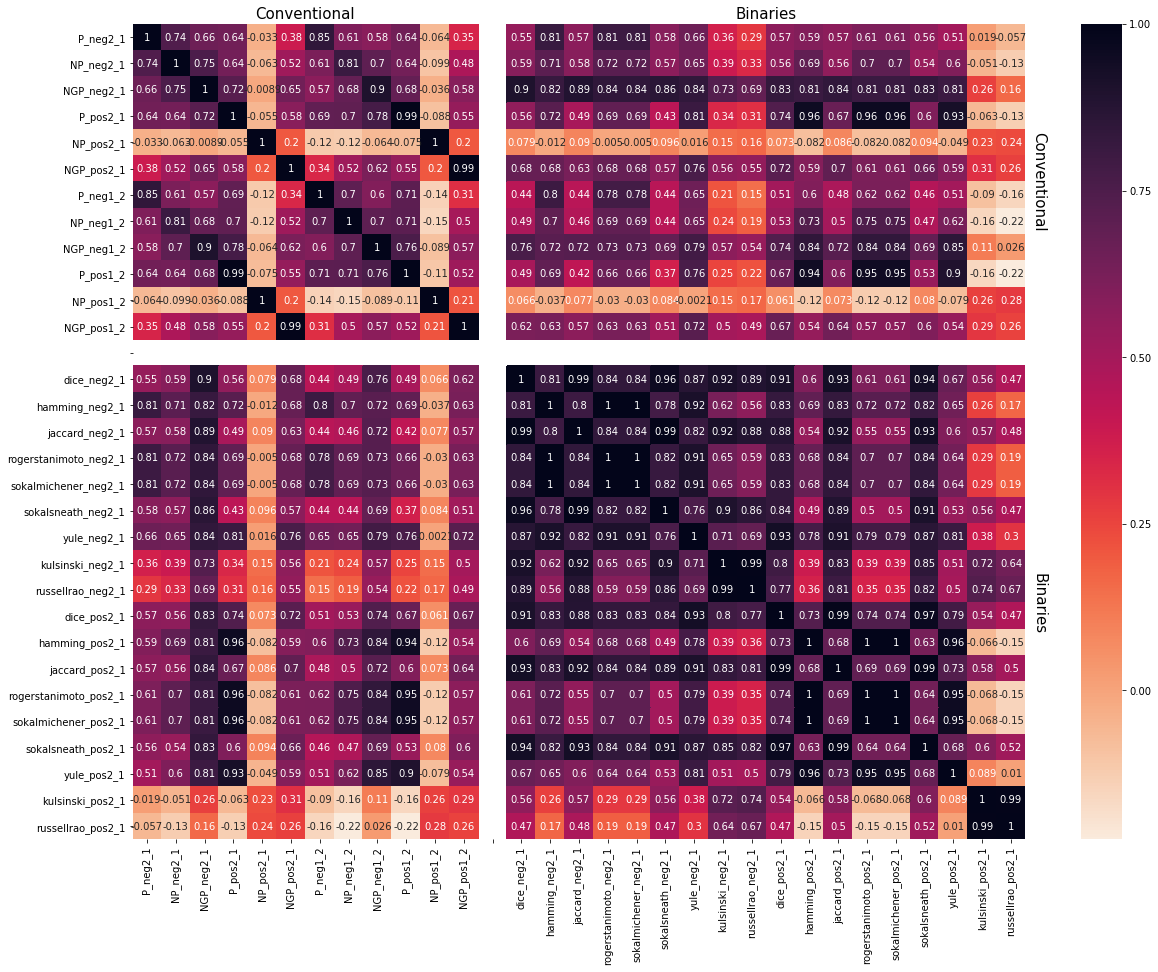

In [64]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [65]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2-1', 'pos2-1', 'neg1-2', 
                                                                                                'pos1-2','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_CI.iloc[13+r,j*3+2]#sum(df_CI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_CI.iloc[22+r,j*3+2]#sum(df_CI.iloc[22+r,j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
Cophenetic

,neg2-1,pos2-1,neg1-2,pos1-2,neg+pos
dice,0.902983,0.715446,0.761516,0.670155,3.050100
hamming,0.821115,0.592520,0.716314,0.544055,2.674004
jaccard,0.888335,0.695779,0.723714,0.642801,2.950628
rogerstanimoto,0.843982,0.613796,0.726542,0.566766,2.751087
sokalmichener,0.843982,0.613796,0.726542,0.566766,2.751087
sokalsneath,0.863889,0.663742,0.688481,0.604968,2.821081
yule,0.841234,0.589943,0.785090,0.538042,2.754308
kulsinski,0.731660,0.308141,0.568886,0.288385,1.897072
russellrao,0.687265,0.262408,0.537248,0.256388,1.743310


### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [66]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


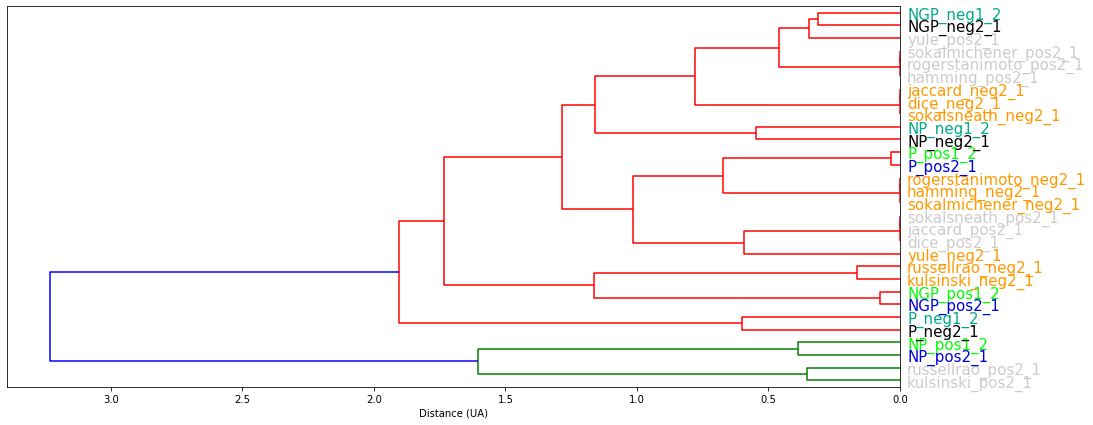

In [67]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


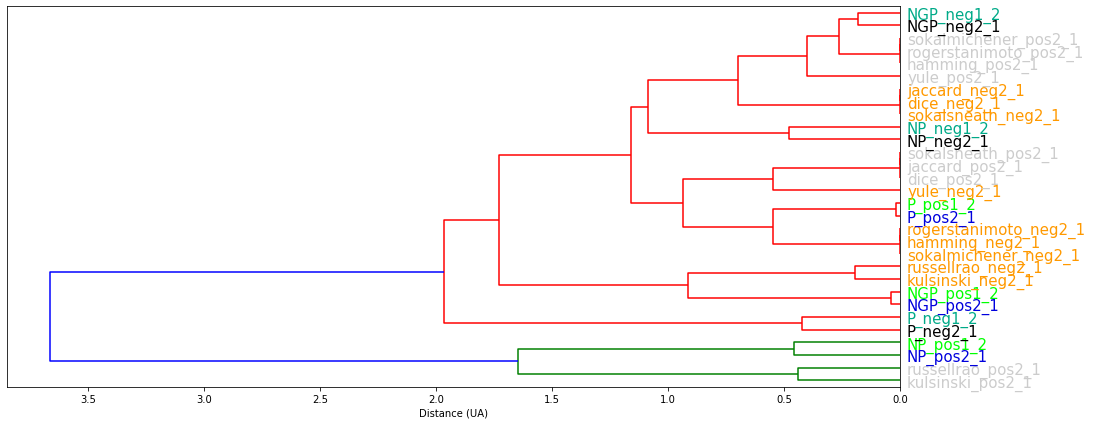

In [68]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.


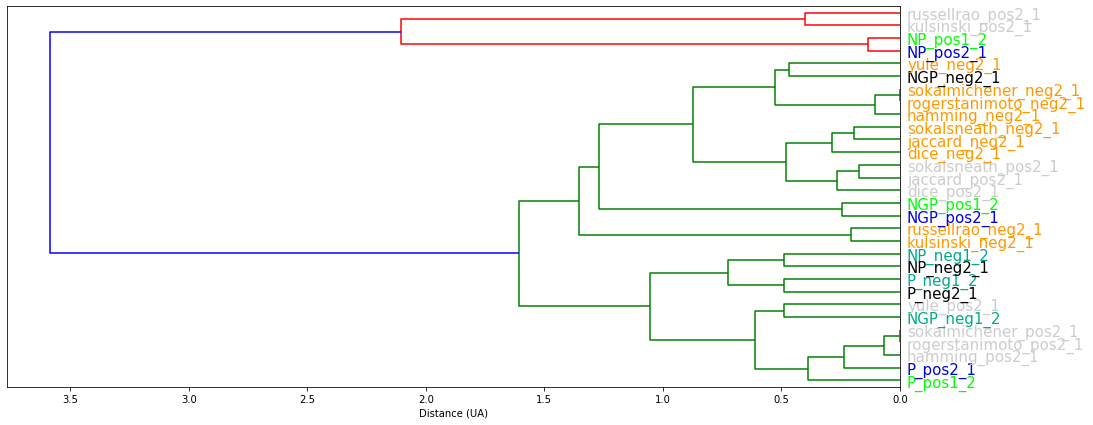

In [69]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('1_2 - Peak alignment requiring that a feature appears in at least 2 samples of all samples.')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [70]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [71]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    data = aligned_all_neg
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

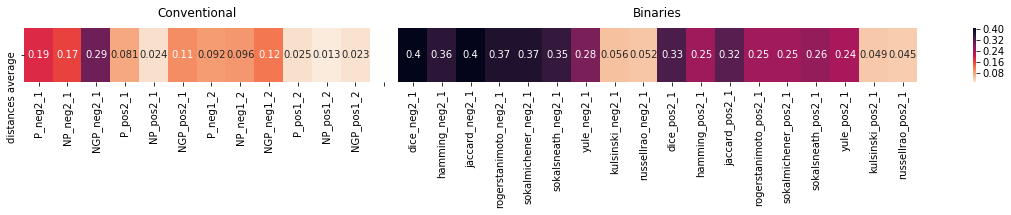

In [72]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

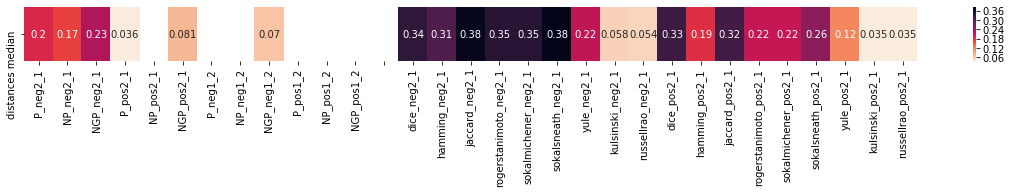

In [73]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

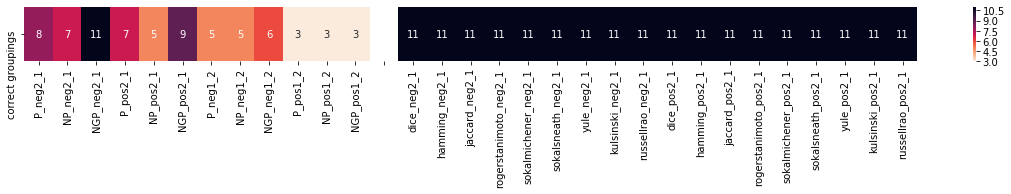

In [74]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [75]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [76]:
Kmean = skclust.KMeans(n_clusters=11)

In [77]:
a = Kmean.fit(NGP_neg.T)

In [78]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{9: ['CAN', 'CAN', 'CAN'],
 10: ['CS', 'CS', 'CS'],
 8: ['LAB', 'LAB', 'LAB'],
 4: ['PN', 'PN', 'PN'],
 5: ['REG', 'REG', 'REG'],
 1: ['RIP', 'RIP', 'RIP'],
 2: ['RL', 'RL', 'RL'],
 0: ['ROT', 'ROT', 'ROT'],
 6: ['RU', 'RU', 'RU'],
 3: ['SYL', 'SYL', 'SYL'],
 7: ['TRI', 'TRI', 'TRI']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the `Kmeans_discrim` function from multianalysis to calculate discrimination distance.

In [79]:
colnames2 = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
             'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
             'binary_neg2_1', 'binary_pos2_1','binary_neg1_2', 'binary_pos1_2']

In [80]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [81]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

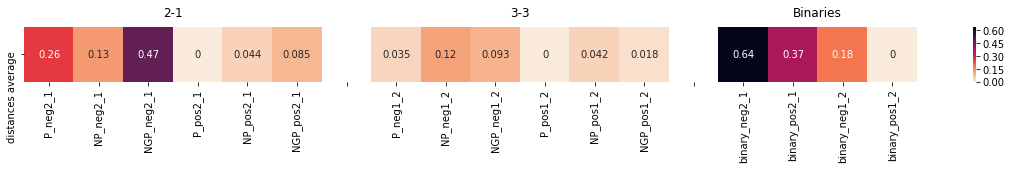

In [82]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

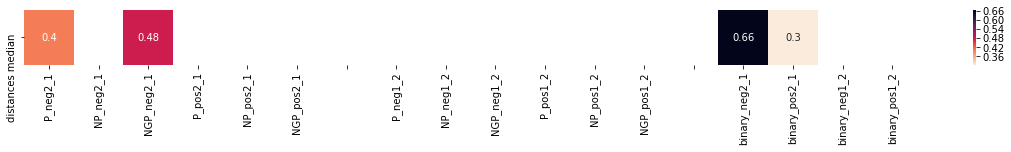

In [83]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

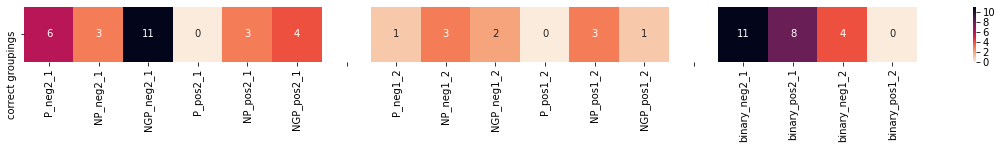

In [84]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

# Just for Alignment 1-2 (True Non-Bias from now on)

#### 2-1 Alignment present in the other "sem3" notebook

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [85]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,600,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [86]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

In [87]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg2 ... Done!
Fitting P_neg2 ... Done!
Fitting NP_neg2 ... Done!
Fitting NGP_neg2 ... Done!
Fitting bin_neg2 ... Done!
Fitting I_pos2 ... Done!
Fitting P_pos2 ... Done!
Fitting NP_pos2 ... Done!
Fitting NGP_pos2 ... Done!
Fitting bin_pos2 ... Done!


Performance based on number of trees - Alignment: 1-2, Negative Mode


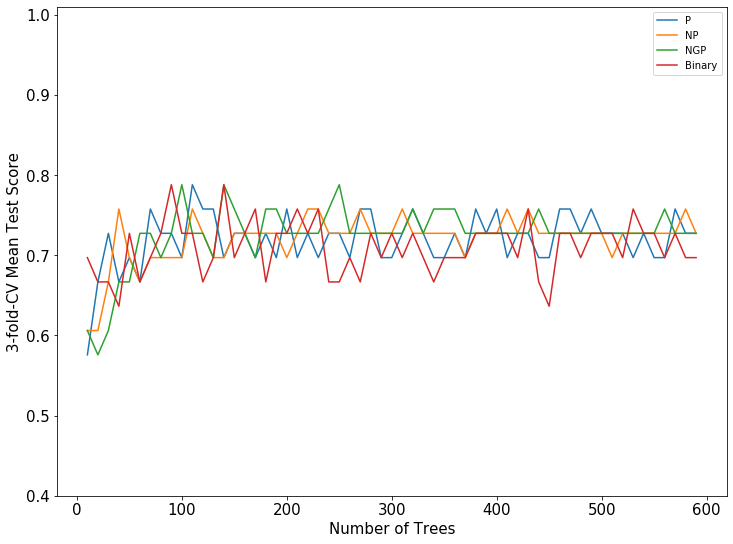

In [88]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(1,5):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Negative Mode')

Performance based on number of trees - Alignment: 1-2, Positive Mode


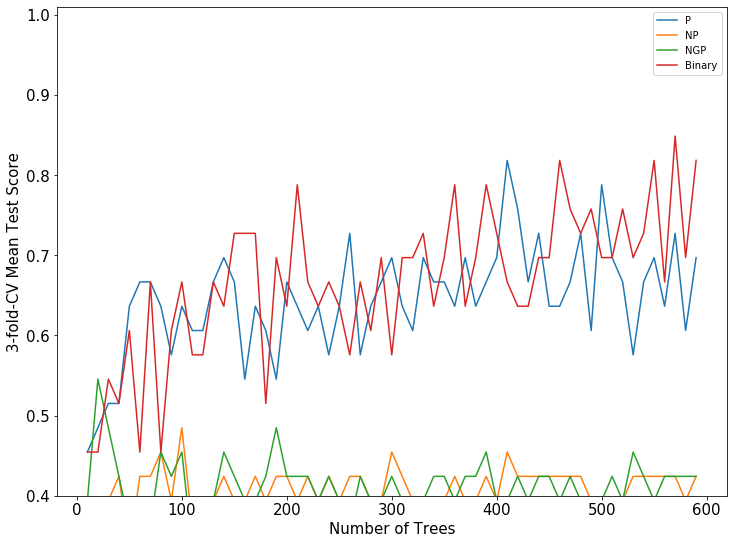

In [89]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(6,10):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Positive Mode')

### Performance of N, NP and NGP data treatments (alignments 2-1 and 1-2)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [90]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [91]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg2 ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for I_pos2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for bin_pos2 ...done


Accuracy based on the dataset


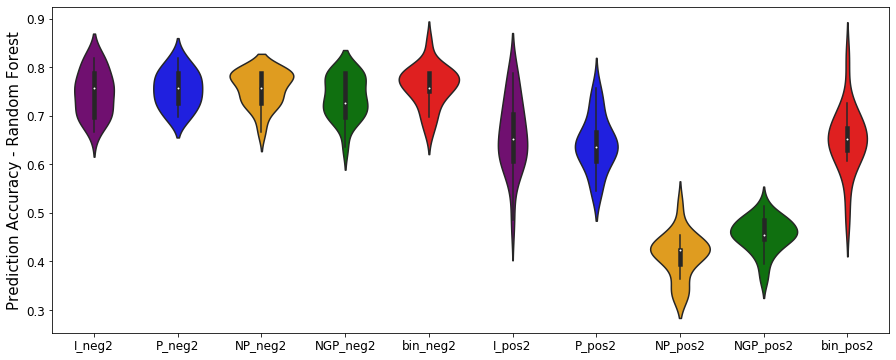

In [92]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [93]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

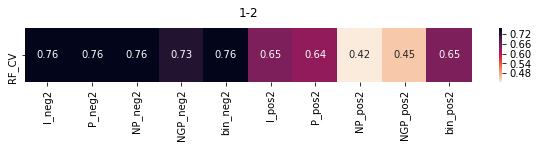

In [94]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

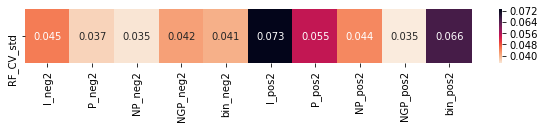

In [95]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [96]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

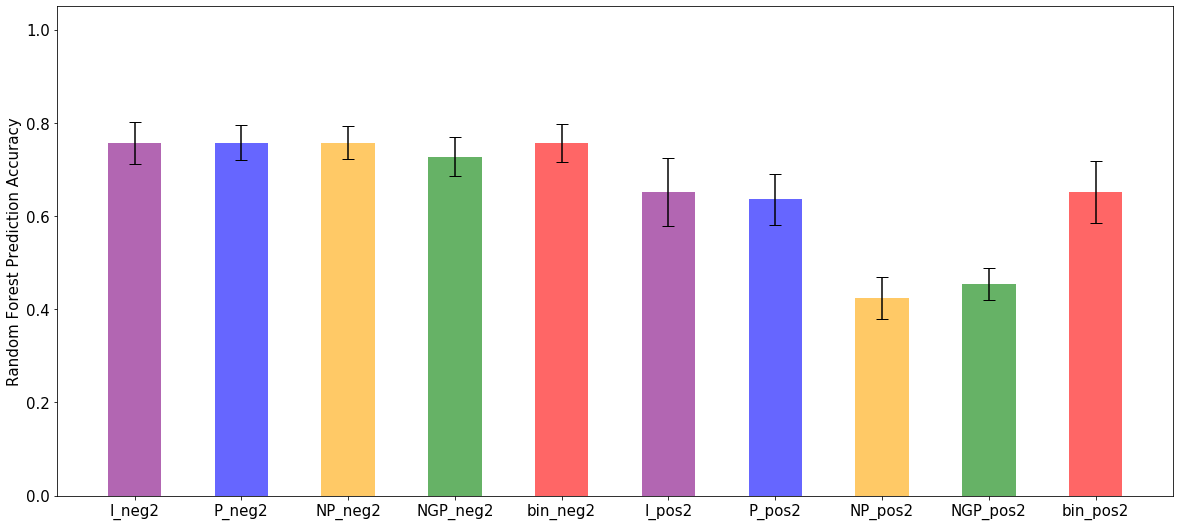

In [97]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated n times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weigth) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function `simple_RF` from multianalysis.

In [98]:
#Preparations of dicts:
#Scores = {}
#Scores_std = {}
#Imp_feat = {}

In [99]:
#part = {}

#part['P_neg2'] = treat_neg2['P']
#part['P_pos2'] = treat_pos2['P']
#part['bin_neg2'] = treat_neg2['binary']
#part['bin_pos2'] = treat_pos2['binary']

In [100]:
#for name, data in part.items():
#    print(f'Fitting random forest for {name} ...', end='')
#    rf, imp_features = ma.simple_RF(data)#, iter_num = 100)
#    Scores[name] = np.mean(rf)
#    Scores_std[name] = np.std(rf)
#    Imp_feat[name] = imp_features
#    print(f'done') 

### Attempt/Method nº2 - SMOTE - Code in markdown, not relevant anymore - maybe take out in next version?

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function `fast_SMOTE` from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
#Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
#glog_S_neg = sca.glog(Norm_S_neg)
Euc_P_S_neg = sca.ParetoScal(Imp_S_neg)#glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
#Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
#glog_S_neg2 = sca.glog(Norm_S_neg2)
Euc_P_S_neg2 = sca.ParetoScal(Imp_S_neg2)#glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
#Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
#glog_S_pos = sca.glog(Norm_S_pos)
Euc_P_S_pos = sca.ParetoScal(Imp_S_pos)#glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
#Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
#glog_S_pos2 = sca.glog(Norm_S_pos2)
Euc_P_S_pos2 = sca.ParetoScal(Imp_S_pos2)#glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

N1_B = ma.simple_RF(Euc_P_S_neg)
Scores['neg2-1_bleed'] = np.mean(N1_B[0])
Scores_std['neg2-1_bleed'] = np.std(N1_B[0])
Imp_feat['neg2-1_bleed'] = N1_B[1]

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary)
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function `RF_M3` from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [101]:
#Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
#Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

In [102]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
#plt.show()

In [103]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive) - Still mean, not median

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 1-2 ('True' Non-Bias)

In [104]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [105]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:5], line, df.iloc[5:10]])

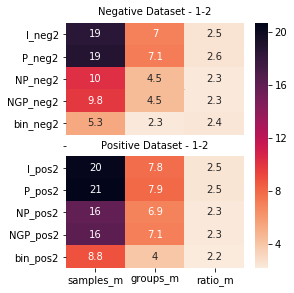

In [106]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,5.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

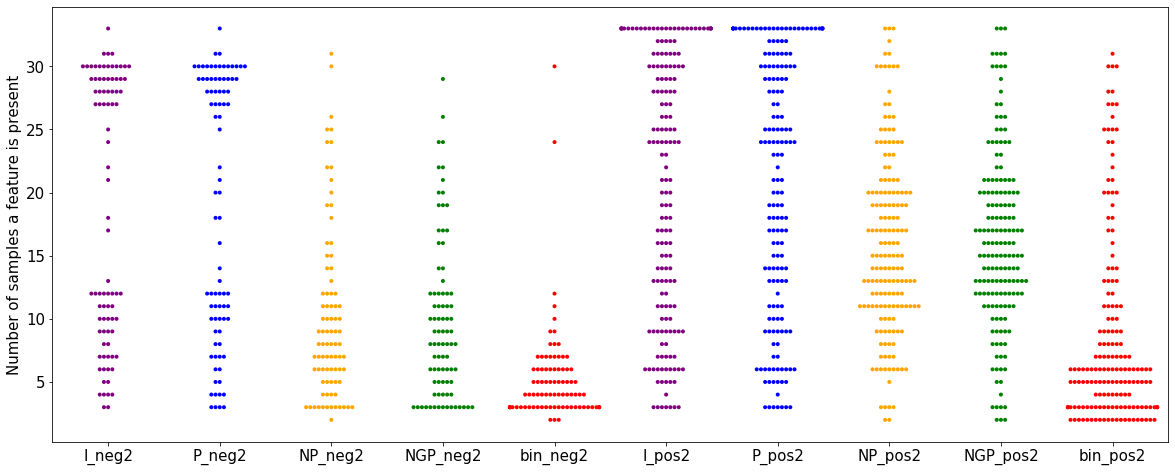

In [107]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [108]:
print('Magnitude of most important feature:', )
for i in range(10):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(10):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg2      	 5.46526160471401
P_neg2      	 5.292693988677435
NP_neg2      	 4.193693995359223
NGP_neg2      	 3.8811180161573815
bin_neg2      	 6.090425918466738
I_pos2      	 14.810235176637885
P_pos2      	 15.852815751828023
NP_pos2      	 9.306633800879194
NGP_pos2      	 8.095098956602971
bin_pos2      	 11.6694366529082


% of model explained by the 2% most important features
I_neg2      	 7.701419700731856
P_neg2      	 7.675589954825975
NP_neg2      	 5.218530860593032
NGP_neg2      	 5.141382839891641
bin_neg2      	 6.795578955270183
I_pos2      	 15.949322821731542
P_pos2      	 15.74937854755338
NP_pos2      	 9.01055183210451
NGP_pos2      	 9.065193198069226
bin_pos2      	 11.101977688437604


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [109]:
matrix = pd.get_dummies(all_labels)
matrix = matrix[['CAN','CS','LAB','PN','REG','RIP','RL','ROT','RU','SYL','TRI']]

In [110]:
# Centralize data again excluding the not Imp / Ionly data
datasets = {}

datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

### Search for the best number of components to use - Alignment 2-1 and 3-3

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [111]:
PLS_optim = {}

In [112]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, matrix, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg2 ...done
Optimizing PLS-DA for NP_neg2 ...done
Optimizing PLS-DA for NGP_neg2 ...done
Optimizing PLS-DA for bin_neg2 ...done
Optimizing PLS-DA for P_pos2 ...done
Optimizing PLS-DA for NP_pos2 ...done
Optimizing PLS-DA for NGP_pos2 ...done
Optimizing PLS-DA for bin_pos2 ...done


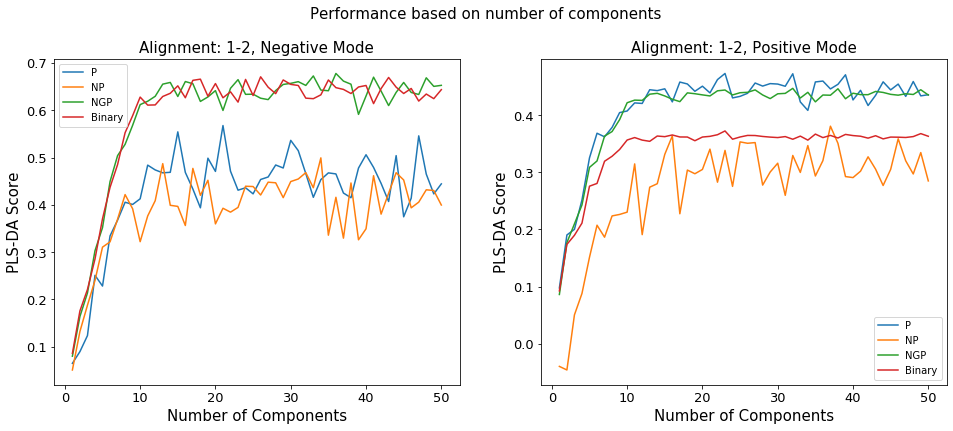

In [113]:
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)

for name, data in PLS_optim.items():
    if name.endswith('neg2'):
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Alignment: 1-2, Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos2'):
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Alignment: 1-2, Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'Binary'))

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [114]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [115]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, matrix, n_comp = 15, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for P_neg2 ...done
Fitting PLS-DA for NP_neg2 ...done
Fitting PLS-DA for NGP_neg2 ...done
Fitting PLS-DA for bin_neg2 ...done
Fitting PLS-DA for P_pos2 ...done
Fitting PLS-DA for NP_pos2 ...done
Fitting PLS-DA for NGP_pos2 ...done
Fitting PLS-DA for bin_pos2 ...done


### Alignment 1-6 ("True" Non-Bias)

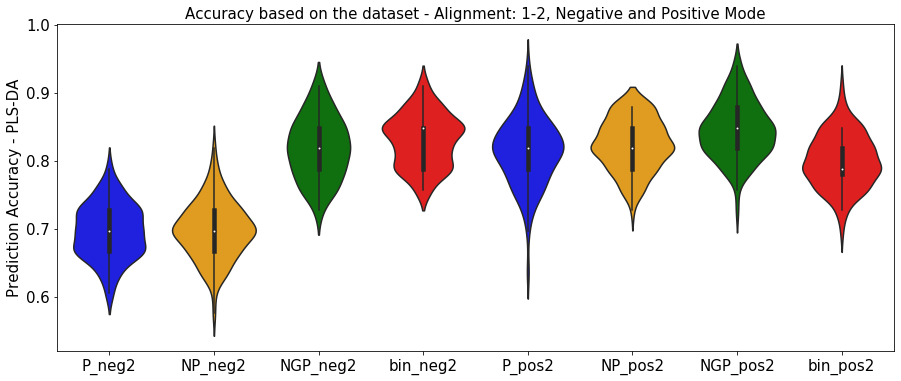

In [116]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu)
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 1-2, Negative and Positive Mode', fontsize = 15)
plt.show()

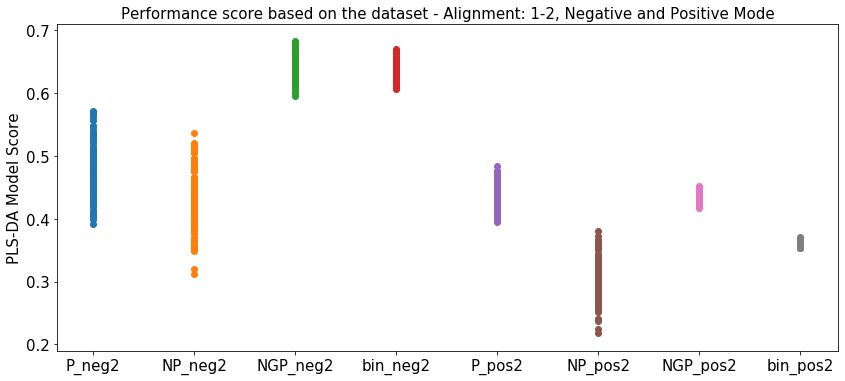

In [117]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 1-2, Negative and Positive Mode', fontsize = 15)
plt.show()

### Medians but also still with standard deviations

In [118]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

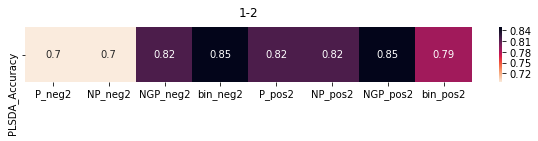

In [119]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

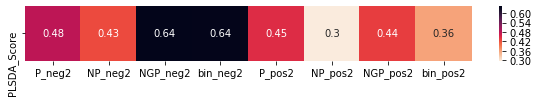

In [120]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [121]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())[:8]
Accuracy_H.T

,Accuracy,SD
P_neg2,0.696970,0.039506
NP_neg2,0.696970,0.041532
NGP_neg2,0.818182,0.045048
bin_neg2,0.848485,0.038331
P_pos2,0.818182,0.048915
NP_pos2,0.818182,0.037207
NGP_pos2,0.848485,0.040944
bin_pos2,0.787879,0.038807


In [122]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())[:8]
Score_H.T

,Score,SD
P_neg2,0.482094,0.043899
NP_neg2,0.427841,0.048520
NGP_neg2,0.643611,0.020694
bin_neg2,0.640919,0.015090
P_pos2,0.450646,0.019221
NP_pos2,0.297216,0.034694
NGP_pos2,0.436629,0.007101
bin_pos2,0.361859,0.004061


### Characteristics of the most important features - still mean (not median)

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [123]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg2'):
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        Spectra = aligned_all_pos2
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [124]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

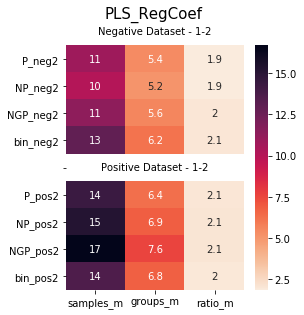

In [125]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

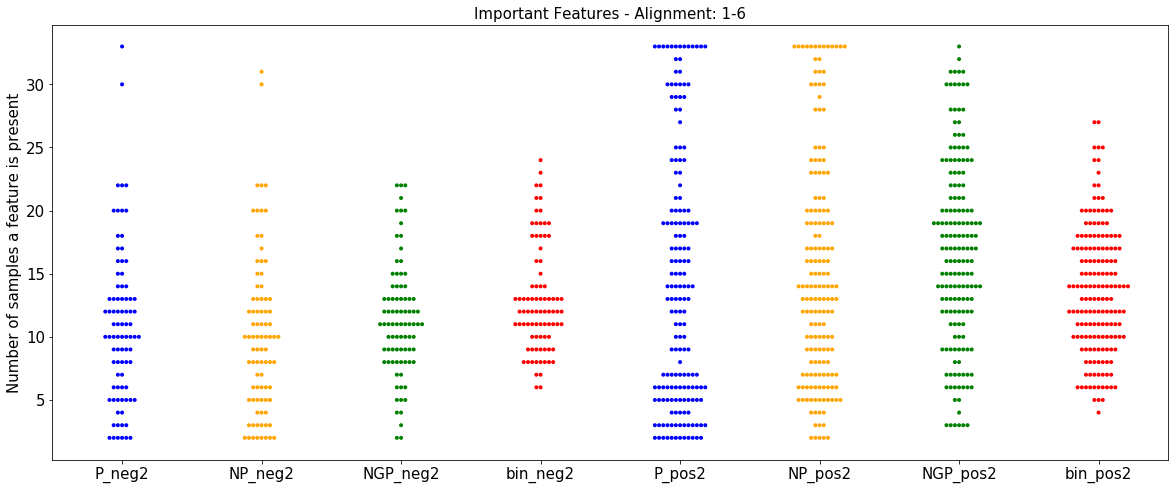

In [126]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 1-6', fontsize = 15)
plt.show()

In [127]:
print('Magnitude of most important features for each case:')
for i in range(8):
    print(list(PLS_feat.keys())[i], '     \t', magni[i])

Magnitude of most important features for each case:
P_neg2      	 16.015227918209266
NP_neg2      	 16.986792073613895
NGP_neg2      	 4.2145809971523365
bin_neg2      	 3.327397568348095
P_pos2      	 25.333924585725807
NP_pos2      	 15.479900519614008
NGP_pos2      	 8.786469007608316
bin_pos2      	 4.063499098337852


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

#### NGP data treatment for the Negative Mode - Alignment: 1-2

In [128]:
from sklearn.cross_decomposition import PLSRegression

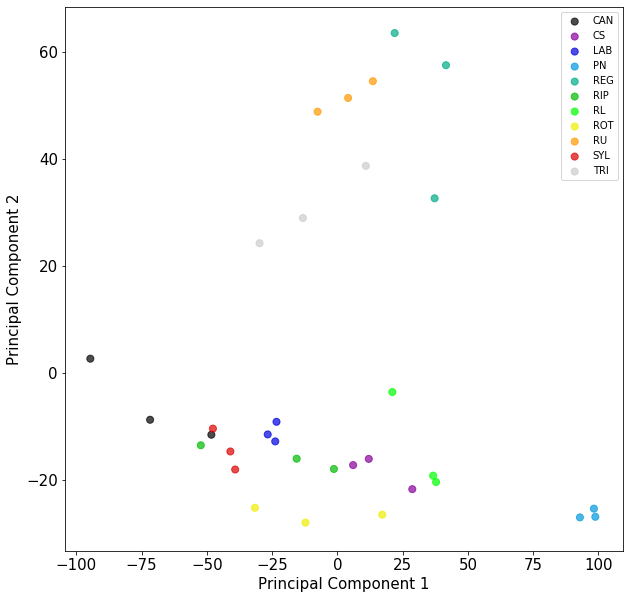

In [129]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 11)
col_lbl = colours(range(11))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
fig = plt.figure(figsize = (10,10))
for i in range(0,42,3):
    plt.scatter(LV_score.iloc[i:i+3,0],LV_score.iloc[i:i+3,1], s=50, alpha=0.7, c = col_lbl[i:i+3])
    #LV_score.iloc[i:i+3,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl[i:i+3])
#ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
plt.xlabel(xlabel = 'Principal Component 1', size = 15)
plt.ylabel(ylabel = 'Principal Component 2', size = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(NGP_pos.cdl.unique_labels,bbox_to_anchor=(1, 1))
plt.show()

#### Binary processed data for the negative mode - Alignment: 1-2

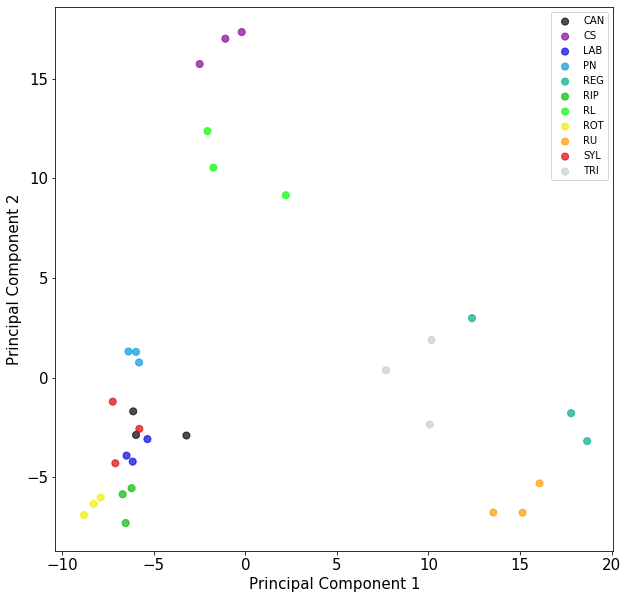

In [130]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=aligned_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 11)
col_lbl = colours(range(11))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
fig = plt.figure(figsize = (10,10))
for i in range(0,42,3):
    plt.scatter(LV_score.iloc[i:i+3,0],LV_score.iloc[i:i+3,1], s=50, alpha=0.7, c = col_lbl[i:i+3])
    #LV_score.iloc[i:i+3,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl[i:i+3])
#ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
plt.xlabel(xlabel = 'Principal Component 1', size = 15)
plt.ylabel(ylabel = 'Principal Component 2', size = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(aligned_pos.cdl.unique_labels,bbox_to_anchor=(1, 1))
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [131]:
CV = {}
PMs = {}
pvalue = {}

In [132]:
all_data = (P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for bin_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for bin_pos2 ...
Done!


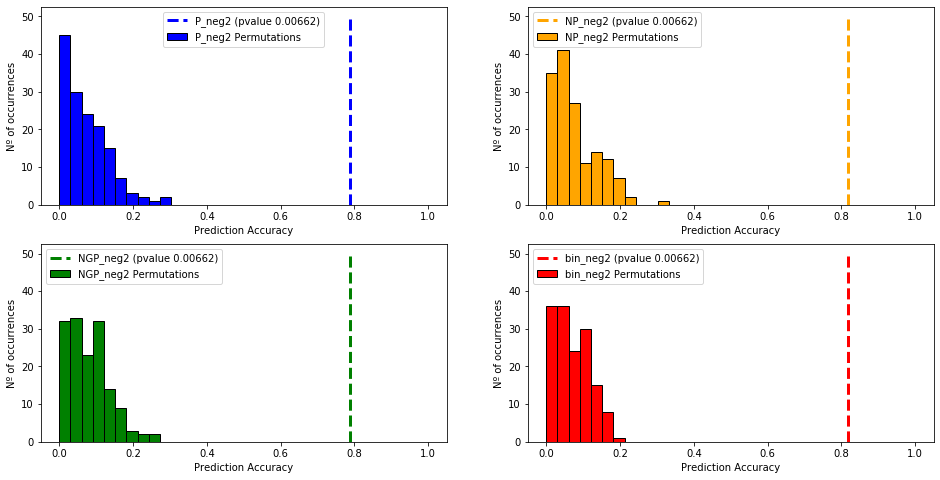

In [133]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

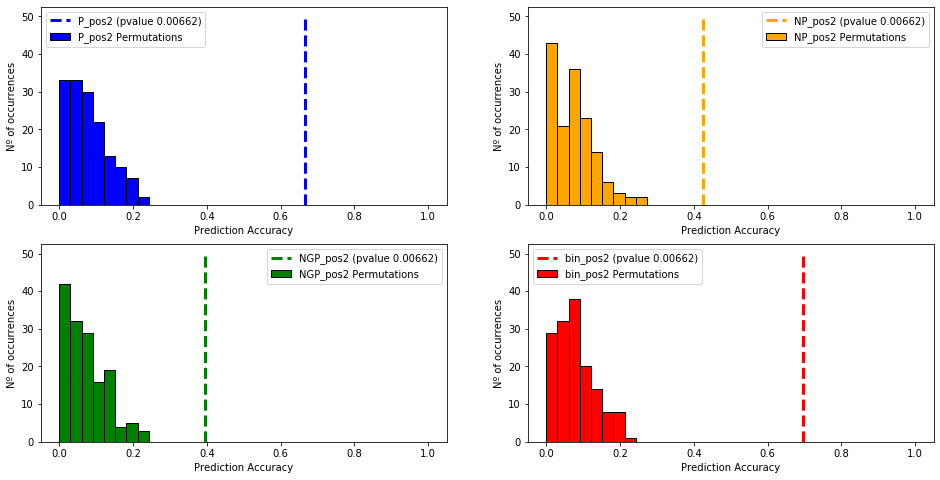

In [134]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [135]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [136]:
all_data = (P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=15, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for P_neg2 ...
Done!
permutation test (PLS-DA) for NP_neg2 ...
Done!
permutation test (PLS-DA) for NGP_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!


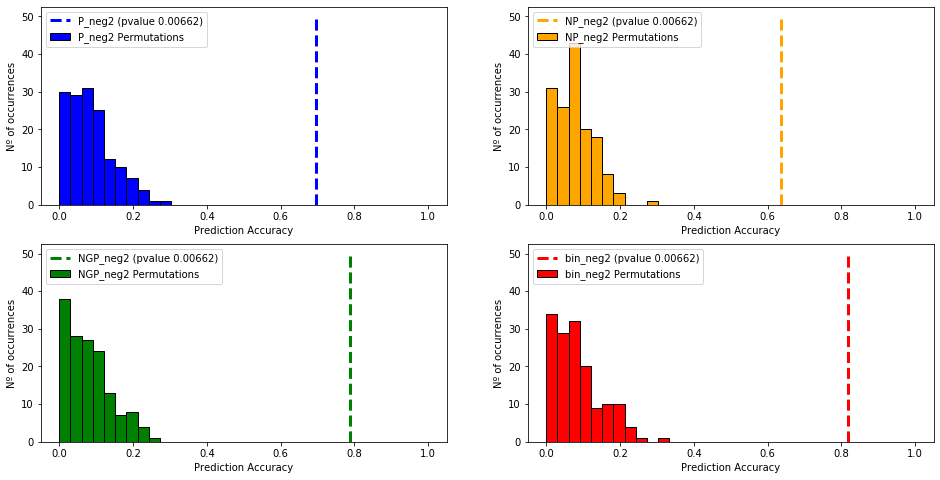

In [137]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

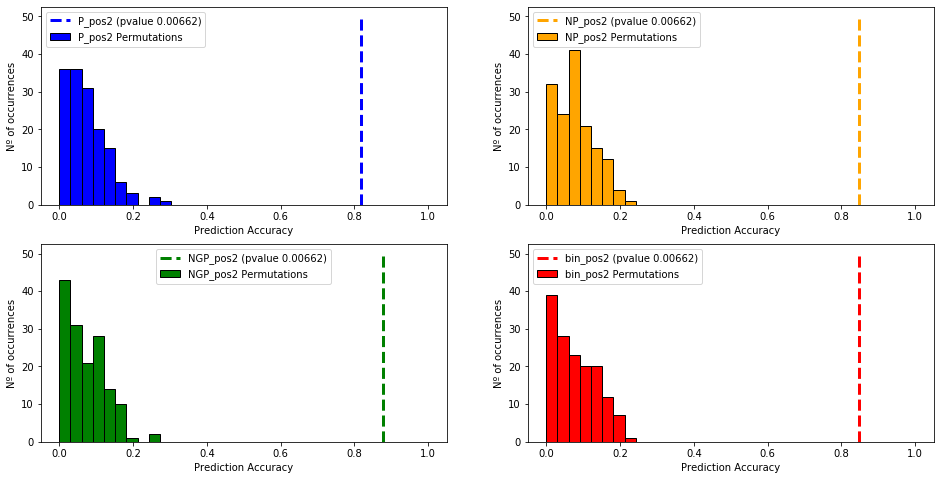

In [138]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()